# Sheridan Kamal

## DATA 71200 - Project 2 (Due 4/29/2020, 11:59p)

### Project
For my project, I will be using time series data and machine learning methods to predict recessions. In this portion of the project, I will be using the training and testing sets created in the previous project to create two supervised machine learning models. I will be creating Logistic Regression models with different C values (0.01, 1, 10, 100) and Decision Tree Classifier models with different max depths (1, 2, 3, 4). The best Logistic Regression model is the model with a C value of 100 and the best Decision Tree Classifier model is the model with a max depth of 1.

### Data
I will be using the CSV file named 'Project Dataset.csv' that I generated in the previous project. Since this file has all of the features I wish to use for my model and the prediction labels are already encoded and the models that I chose do not require the data to be scaled there is nothing else that needs to be done to the data.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

data = pd.read_csv('Project Dataset.csv', sep = ',', parse_dates = ['Date'], index_col = 'Date')
data.head()

,10yr Tbond,2yr Spread,Fedrate,% Change Payrolls,CPI,% Change 12M,Recession
Date,,,,,,,
1976-06-01,7.86,0.80,5.48,0.000807,56.7,0.091205,0.0
1976-07-01,7.83,0.98,5.31,0.002154,57.0,0.153168,0.0
1976-08-01,7.77,1.14,5.29,0.001974,57.3,0.169327,0.0
1976-09-01,7.59,1.17,5.25,0.002359,57.6,0.226975,0.0
1976-10-01,7.41,1.43,5.02,0.000238,57.9,0.144672,0.0


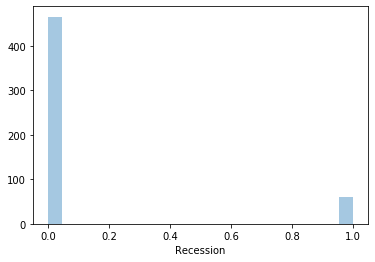

In [2]:
sns.distplot(data.loc[:, 'Recession'], kde=False) #0 = No Recession, 1 = Recession

In [3]:
#70/30 sequential train-test split
from sklearn.model_selection import train_test_split

X = data.iloc[:, 0:-1]
y = data.loc[:, 'Recession']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, shuffle=False, random_state=1)

In [4]:
#For cross validation
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

index = 1
for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    print('Split %d.' % index, 'Training set observations: %d,' % len(train_index), 'Testing set observations: %d' % len(test_index))
    index += 1

Split 1. Training set observations: 91, Testing set observations: 87
Split 2. Training set observations: 178, Testing set observations: 87
Split 3. Training set observations: 265, Testing set observations: 87
Split 4. Training set observations: 352, Testing set observations: 87
Split 5. Training set observations: 439, Testing set observations: 87


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

logmodel001 = LogisticRegression(C=0.01)
logmodel001.fit(X_train, y_train)
logpredict001 = logmodel001.predict(X_test)
print("Training set score: {:.3f}".format(logmodel001.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logmodel001.score(X_test, y_test)))
print(classification_report(y_test, logpredict001))

Training set score: 0.886
Test set score: 0.880
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       139
         1.0       0.00      0.00      0.00        19

    accuracy                           0.88       158
   macro avg       0.44      0.50      0.47       158
weighted avg       0.77      0.88      0.82       158



In [6]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
logpredict = logmodel.predict(X_test)
print("Training set score: {:.3f}".format(logmodel.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logmodel.score(X_test, y_test)))
print(classification_report(y_test, logpredict))

Training set score: 0.913
Test set score: 0.880
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       139
         1.0       0.00      0.00      0.00        19

    accuracy                           0.88       158
   macro avg       0.44      0.50      0.47       158
weighted avg       0.77      0.88      0.82       158



In [7]:
logmodel10 = LogisticRegression(C=10)
logmodel10.fit(X_train, y_train)
logpredict10 = logmodel10.predict(X_test)
print("Training set score: {:.3f}".format(logmodel10.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logmodel10.score(X_test, y_test)))
print(classification_report(y_test, logpredict10))

Training set score: 0.908
Test set score: 0.930
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       139
         1.0       1.00      0.42      0.59        19

    accuracy                           0.93       158
   macro avg       0.96      0.71      0.78       158
weighted avg       0.94      0.93      0.92       158



In [8]:
#Best logistic regression model
logmodel100 = LogisticRegression(C=100)
logmodel100.fit(X_train, y_train)
logpredict100 = logmodel100.predict(X_test)
print("Training set score: {:.3f}".format(logmodel100.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logmodel100.score(X_test, y_test)))
print(classification_report(y_test, logpredict100))

Training set score: 0.916
Test set score: 0.937
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97       139
         1.0       1.00      0.47      0.64        19

    accuracy                           0.94       158
   macro avg       0.97      0.74      0.80       158
weighted avg       0.94      0.94      0.93       158



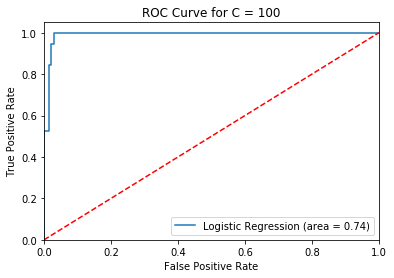

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logmodel100.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel100.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for C = 100')
plt.legend(loc="lower right")
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score

logscore = cross_val_score(logmodel100, X, y, cv=tscv, scoring='accuracy')

i = 0
for i in range(len(logscore)):
    print('Split %d accuracy:' % (i + 1), logscore[i])
    i += 1

Split 1 accuracy: 0.6436781609195402
Split 2 accuracy: 1.0
Split 3 accuracy: 0.9310344827586207
Split 4 accuracy: 0.8850574712643678
Split 5 accuracy: 1.0


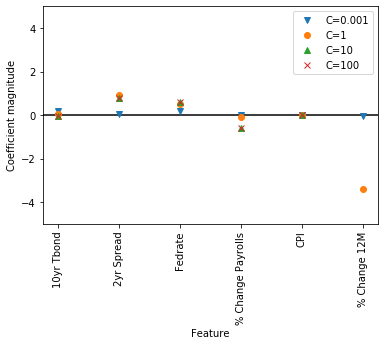

In [11]:
plt.plot(logmodel001.coef_.T, 'v', label="C=0.001")
plt.plot(logmodel.coef_.T, 'o', label="C=1")
plt.plot(logmodel100.coef_.T, '^', label="C=10")
plt.plot(logmodel100.coef_.T, 'x', label="C=100")
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.ylim(-5, 5)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()

In [12]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

In [13]:
from sklearn.tree import DecisionTreeClassifier

#Best decision tree classifier model
dtmodel = DecisionTreeClassifier(max_depth=1, random_state=1)
dtmodel.fit(X_train, y_train)
dtpredict = dtmodel.predict(X_test)
print("Training set score: {:.3f}".format(dtmodel.score(X_train, y_train)))
print("Test set score: {:.3f}".format(dtmodel.score(X_test, y_test)))
print(classification_report(y_test, dtpredict))

Training set score: 0.943
Test set score: 0.930
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       139
         1.0       0.68      0.79      0.73        19

    accuracy                           0.93       158
   macro avg       0.83      0.87      0.85       158
weighted avg       0.94      0.93      0.93       158



In [14]:
dtscore = cross_val_score(dtmodel, X, y, cv=tscv, scoring='accuracy')

i = 0
for i in range(len(dtscore)):
    print('Split %d accuracy:' % (i + 1), dtscore[i])
    i += 1

Split 1 accuracy: 0.9885057471264368
Split 2 accuracy: 0.896551724137931
Split 3 accuracy: 0.896551724137931
Split 4 accuracy: 0.8850574712643678
Split 5 accuracy: 0.9885057471264368


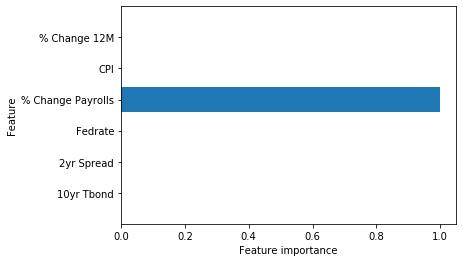

In [15]:
plot_feature_importances(dtmodel)

[Text(167.4, 163.07999999999998, 'X[3] <= -0.001\ngini = 0.202\nsamples = 368\nvalue = [326, 42]\nclass = y[0]'),
 Text(83.7, 54.360000000000014, 'gini = 0.369\nsamples = 41\nvalue = [10, 31]\nclass = y[1]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.065\nsamples = 327\nvalue = [316, 11]\nclass = y[0]')]

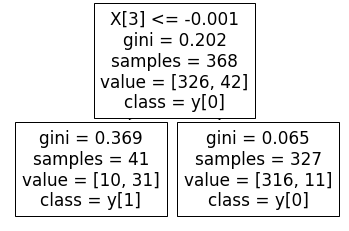

In [16]:
from sklearn import tree

tree.plot_tree(dtmodel.fit(X_train, y_train), class_names=True)

In [17]:
dtmodel2 = DecisionTreeClassifier(max_depth=2, random_state=1)
dtmodel2.fit(X_train, y_train)
dtpredict2 = dtmodel2.predict(X_test)
print("Training set score: {:.3f}".format(dtmodel2.score(X_train, y_train)))
print("Test set score: {:.3f}".format(dtmodel2.score(X_test, y_test)))
print(classification_report(y_test, dtpredict2))

Training set score: 0.959
Test set score: 0.911
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       139
         1.0       1.00      0.26      0.42        19

    accuracy                           0.91       158
   macro avg       0.95      0.63      0.68       158
weighted avg       0.92      0.91      0.89       158



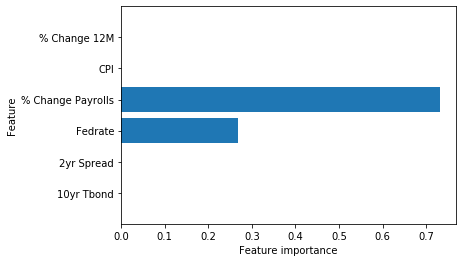

In [18]:
plot_feature_importances(dtmodel2)

In [19]:
dtmodel3 = DecisionTreeClassifier(max_depth=3, random_state=1)
dtmodel3.fit(X_train, y_train)
dtpredict3 = dtmodel3.predict(X_test)
print("Training set score: {:.3f}".format(dtmodel3.score(X_train, y_train)))
print("Test set score: {:.3f}".format(dtmodel3.score(X_test, y_test)))
print(classification_report(y_test, dtpredict3))

Training set score: 0.978
Test set score: 0.911
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       139
         1.0       1.00      0.26      0.42        19

    accuracy                           0.91       158
   macro avg       0.95      0.63      0.68       158
weighted avg       0.92      0.91      0.89       158



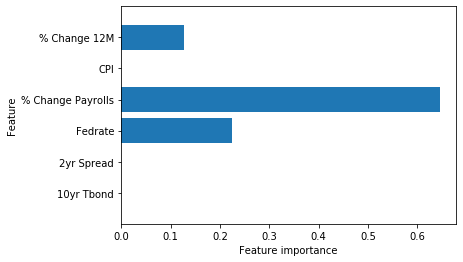

In [20]:
plot_feature_importances(dtmodel3)

In [21]:
dtmodel4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtmodel4.fit(X_train, y_train)
dtpredict4 = dtmodel4.predict(X_test)
print("Training set score: {:.3f}".format(dtmodel4.score(X_train, y_train)))
print("Test set score: {:.3f}".format(dtmodel4.score(X_test, y_test)))
print(classification_report(y_test, dtpredict4))

Training set score: 0.989
Test set score: 0.911
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       139
         1.0       1.00      0.26      0.42        19

    accuracy                           0.91       158
   macro avg       0.95      0.63      0.68       158
weighted avg       0.92      0.91      0.89       158



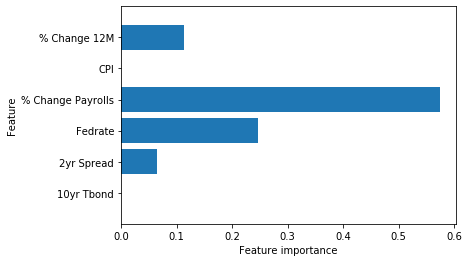

In [22]:
plot_feature_importances(dtmodel4)